In [ ]:
#reading and preprocessing of the data
import numpy as np
import pandas as pd
df2 = pd.read_csv('/content/ТЗ аналитик данных Дулесов Егор - Тестовые заемщики.csv',header=0)[1:].reset_index(drop=True)
df2 = df2.drop('Unnamed: 6', axis=1)

for column in ['Loan issued','Earned interest','Unpaid,  full amount','EL','Comission, %']:
    df2[column] = df2[column].apply(lambda x: float(''.join(filter(str.isdigit, x))))
    if column in ['Comission, %','EL']:
        df2[column] = df2[column].apply(lambda x:x/10000)

df2['учредителю подсказывают / на ВИ другой человек'] = df2['учредителю подсказывают / на ВИ другой человек'].astype(float)

df2['ProfitPercentage'] = ((df2['Earned interest'] - df2['Unpaid,  full amount']*df2['EL'])+df2['Comission, %']*df2['Loan issued'])/df2['Loan issued']

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 29 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Loan issued                                                                       532 non-null    float64
 1   Рейтинг                                                                           532 non-null    float64
 2   Comission, %                                                                      532 non-null    float64
 3   Earned interest                                                                   532 non-null    float64
 4   Unpaid,  full amount                                                              532 non-null    float64
 5   EL                                                                                532 non-null    float64
 6   уч

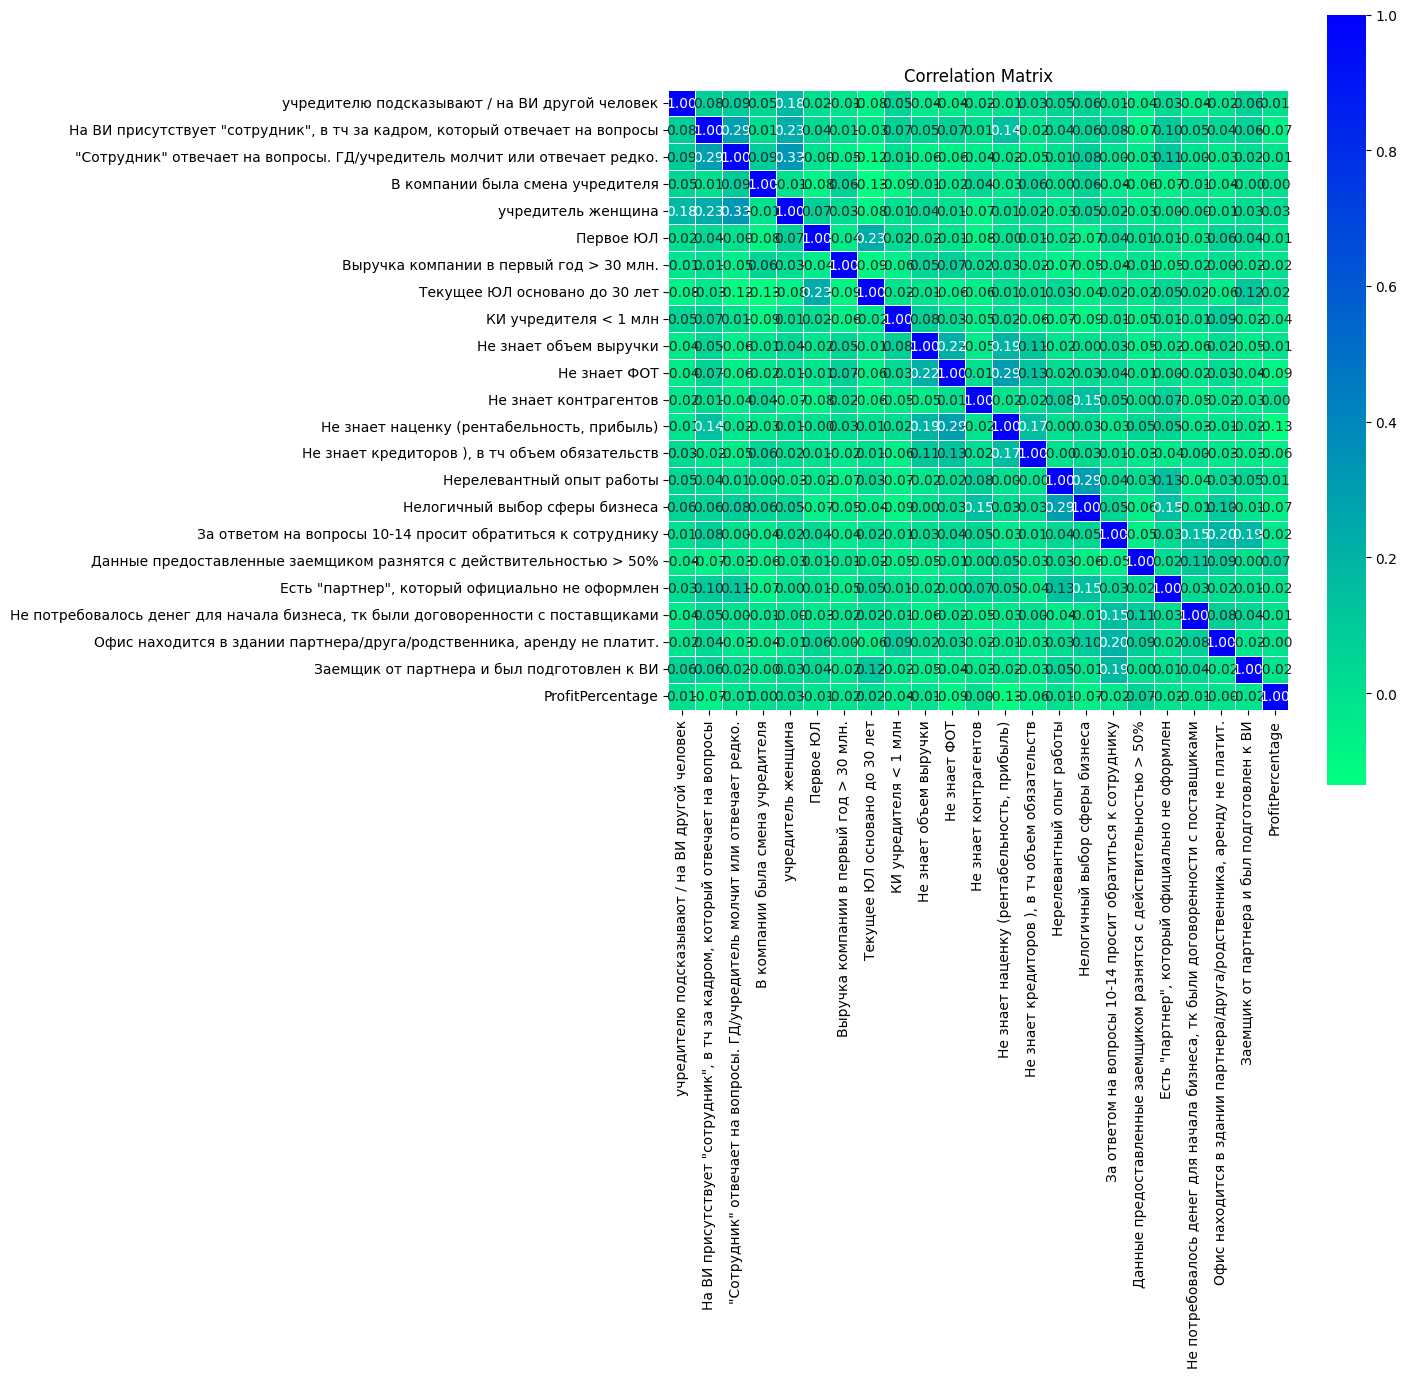

In [ ]:
#data for modelling
import matplotlib.pyplot as plt
import seaborn as sns

data = df2.iloc[:,6:]

corr = data.corr()

fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,annot=True,cmap='winter_r',fmt='.2f',square=True,linewidths=.5,ax=ax)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
data[data.duplicated()].shape[0]

0

In [ ]:
data['ProfitPercentage'].describe()

count    532.000000
mean       0.061413
std        0.116707
min       -1.104846
25%        0.053643
50%        0.079429
75%        0.104828
max        0.217209
Name: ProfitPercentage, dtype: float64

Данные считаны и подготовленны для моделирования. В данных нет пропущенных значений, дупликатов и высоких значений корреляции. Все колонки также необходимого типа.

Изучив задание, я понял, что необходимо написать модель бинарной классификации, так как требуется, чтобы вывод модели отвечал на вопрос "стоит ли выдавать заем?". Таким образом, модель должна делить клиентов на "плохих" и "хороших".

Кроме того, в заднии говорится о том, что необходимо максимизировать совокупную экономическую прибыль. Эту формулировку я понимаю, как задачу максимизации общей прибыли компании, вычисляемой, как сумма profit% по всем клиентам.

Исходя из этих вводных, я пришел к нескольким идеям:

1. Первая идея:

Нам необходимо решить задачу классификации и одновременно максимизировать совокупную прибыль компании, однако в данных отсутствует таргет - целевая переменная, делящая наблюдения на классы. Таким образом, писать модель классификации сразу нельзя. Необходимо сгенерировать таргет. Итак, первая идея заключается в том, чтобы кластеризовать имеющиеся данные (так как мы имеем дело с обучением без учителя), далее выделить наиболее "прибыльный" кластер клиентов и на основе этого создать необходимый таргет - клиентам самого прибыльного кластера присвоить положительный класс (1), остальным клиентам - отрицательный (0). Наконец, обучить модель классификации со сгенерированным таргетом. Такая модель позволит нам выявлять самых прибыльных клиентов, отказывая в займе убыточным или с низкой прибыльностью.

- У этого подхода есть очевидные минусы: При кластеризации есть вероятность "потери" прибыльных клиентов, которые могут быть отнесены моделью в другой кластер.

2. Вторая идея:

Так как в данных нет таргета для классификации, но есть посчитанная переменная profit%, можно обратиться в регрессии. Идея заключается в том, чтобы обучить модель регрессии предсказывать profit% по данным факторам, далее выбрать некий порог profit%. Этот порог будет сигнализировать о том, попал ли клиент в категорию "прибыльный" или нет. То есть здесь необходимо выбрать пороговый процент прибыли, которую принесет клиент компании, ради которой компания, собственно, будет готова тратить свои ресурсы. Например, если клиент принесет 5% прибыли, то мы готовы дать ему займ, если 1% прибыли - не готовы. Таким образом, регрессионная модель будет предсказывать profit%, а далее на основе порогового значения принимается решение по клиенту.

- Основным минусом этого подхода является недостаток информации. Имея лишь эти данные и краткие формулировки задачи, я, к сожалению, никак не могу посчитать это пороговое значение profit%. Не могу даже предположить. Кроме того, в условиях также нет информации о том, ограничены ли ресурсы компании - нужно ли нам искать наиболее прибыльных клиентов, игнорируя тех, кто принесет низкий profit%.

3. Третья идея:

Наиболее логичная и понятная идея. Логика такова. Если нам необходимо максимизировать прибыль компании и решить задачу классификации, то присвоим клиентам с отрицательным profit% класс 0, а клиентам с положительным profit% - класс 1. Таким образом, мы получаем необходимый таргет для классификации, а также максимизируем совокупную прибыль компании, выдавая займ всем клиентам, которые принесут хоть какой-то положительный profit%.

- Здесь проблемы могу возникнуть, если данные плохо сбалансированы. То есть если в данных очень много положительных profit% и мало отрицательных, то модель не сможет хорошо обучиться.


Далее будет реализация описанных выше идей.

Первый подход - Кластеризация

[1148.4041353383461, 1011.6777108433732, 931.9571032519567, 871.4777336139047, 835.1805231404305, 795.2714630655576, 770.949755173893, 738.3241518465433, 736.8186310096195, 705.7957106837948]


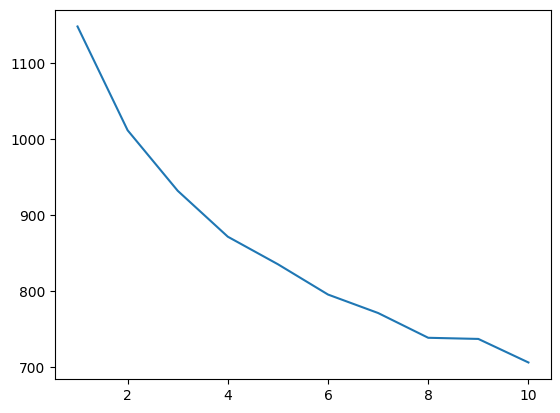

In [ ]:
#Kmeans clustering
from sklearn.cluster import KMeans

#run clustering with different number of clusters
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, max_iter=1000, random_state=123)
    kmeans.fit(data.iloc[:,0:-1])
    wcss.append(kmeans.inertia_)

#print elbow plot
print(wcss)
plt.plot(range(1,11),wcss)
plt.show()

Elbow plot показывает, что нет определенного количества кластеров для эффективного разделения данных. Таким образом, kmeans кластеризация не дает результатов.

Text(0, 0.5, 'Euclidean distance')

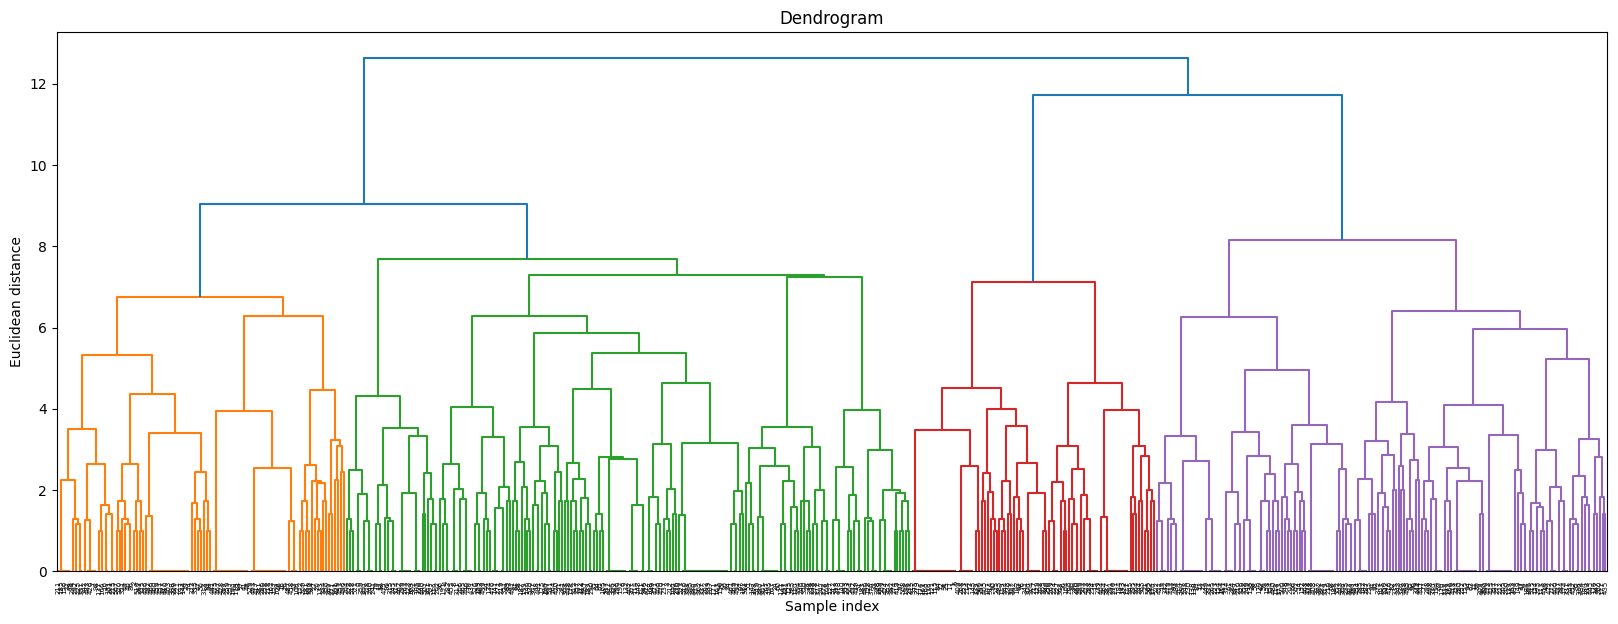

In [ ]:
#Hierarhcical clustering
import scipy.cluster.hierarchy as sc

#plot dendrogram
plt.figure(figsize=(20, 7))
plt.title("Dendrograms")

#create dendrogram
sc.dendrogram(sc.linkage(data.iloc[:,0:-1], method='ward'))

plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')

Из дендограммы делаем вывод, что наиболее подходящее количество кластеров - 3.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

#clustering params
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')

#clustering
cluster.fit(data.iloc[:,0:-1])
data_hcl = data.copy()
data_hcl['labels'] = cluster.labels_

#mean profit in clusters
data_hcl.groupby('labels')['ProfitPercentage'].mean()

labels
0    0.063545
1    0.056478
2    0.063083
Name: ProfitPercentage, dtype: float64

Иерархическая кластеризация также не принесла результатов, так как разделение данных относительно ключевой переменной не помогает выделить наиболее и наименее прибыльный кластер клиентов. Таким образом, первая идея, основанная на предварительной кластеризации и выявлении "хорошего" сегмента данных, несостоятельная. По крайней мере на имеющемся наборе данных.

Второй подход - классификация на основе положительного и отрицательного profit%

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score,recall_score,f1_score,roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import xgboost as xgb
import re

#preparing the data - creating target variable
data_cl = data.copy()
for i in data_cl.columns[:-1]:
    data_cl[i] = data_cl[i].astype(int)
data_cl['target'] = np.where(data_cl['ProfitPercentage'] < 0, 0, 1)
target = data_cl['target']
data_cl = data_cl.drop(['ProfitPercentage', 'target'], axis=1)
print(target.shape, data_cl.shape)

(532,) (532, 22)


In [ ]:
#train test split
X_train,X_test,Y_train,Y_test = train_test_split(data_cl, target, test_size=0.2,random_state=123)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(425, 22) (107, 22) (425,) (107,)


In [ ]:
#random forest
RFC = RandomForestClassifier(class_weight = {0:13,1:1})

cv = KFold(n_splits=5, shuffle=True, random_state=314)

params_grid_RFC = {'n_estimators': range(10,200,10),
                  'max_features':['sqrt', 'log2', None],
                  'criterion':['gini', 'entropy'],}

gs = GridSearchCV(RFC, param_grid=params_grid_RFC, cv = cv)
gs.fit(X_train, Y_train)
print(f'Random Forest performance\n{gs.best_params_}')
print(f'f1_score {round(f1_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, accuracy {round(accuracy_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, precision {round(precision_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, recall {round(recall_score(Y_test,gs.best_estimator_.predict(X_test)),3)}')

y_pred = gs.best_estimator_.predict(X_test)

confusion_matrix(Y_test,y_pred, labels=(1,0))

Random Forest performance
{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 140}
f1_score 0.908, accuracy 0.832, precision 0.918, recall 0.899


array([[89, 10],
       [ 8,  0]])

In [ ]:
#logistic regression
LR = LogisticRegression(class_weight = {0:13,1:1})

cv = KFold(n_splits=5, shuffle=True, random_state=314)

params_grid_LR = {
    'C': np.logspace(-9, 1, 50),
}

gs = GridSearchCV(LR, param_grid=params_grid_LR, cv = cv)
gs.fit(X_train, Y_train)
print(f'Logistic Regression performance\n{gs.best_params_}')
print(f'f1_score {round(f1_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, accuracy {round(accuracy_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, precision {round(precision_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, recall {round(recall_score(Y_test,gs.best_estimator_.predict(X_test)),3)}')

y_pred = gs.best_estimator_.predict(X_test)

confusion_matrix(Y_test,y_pred, labels=(1,0))

Logistic Regression performance
{'C': 0.5963623316594636}
f1_score 0.8, accuracy 0.673, precision 0.921, recall 0.707


array([[70, 29],
       [ 6,  2]])

In [ ]:
#decision tree
DT = DecisionTreeClassifier(class_weight = {0:13,1:1})

cv = KFold(n_splits=5, shuffle=True, random_state=314)

params_grid_DT = {'max_features':['sqrt', 'log2', None],
                  'criterion':['gini', 'entropy'],}

gs = GridSearchCV(DT, param_grid=params_grid_DT, cv = cv)
gs.fit(X_train, Y_train)
print(f'Decision Tree performance\n{gs.best_params_}')
print(f'f1_score {round(f1_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, accuracy {round(accuracy_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, precision {round(precision_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, recall {round(recall_score(Y_test,gs.best_estimator_.predict(X_test)),3)}')

y_pred = gs.best_estimator_.predict(X_test)

confusion_matrix(Y_test,y_pred, labels=(1,0))

Decision Tree performance
{'criterion': 'entropy', 'max_features': 'log2'}
f1_score 0.856, accuracy 0.748, precision 0.909, recall 0.808


array([[80, 19],
       [ 8,  0]])

In [ ]:
#gradient boosting
GB = GradientBoostingClassifier()

cv = KFold(n_splits=5, shuffle=True, random_state=314)

params_grid_GB = {'n_estimators': range(10,200,10),
                  'max_features':['sqrt', 'log2', None],
                  'criterion':['friedman_mse', 'squared_error'],}

gs = GridSearchCV(GB, param_grid=params_grid_GB, cv = cv)
gs.fit(X_train, Y_train)
print(f'Gradient Boosting performance\n{gs.best_params_}')
print(f'f1_score {round(f1_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, accuracy {round(accuracy_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, precision {round(precision_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, recall {round(recall_score(Y_test,gs.best_estimator_.predict(X_test)),3)}')

y_pred = gs.best_estimator_.predict(X_test)

confusion_matrix(Y_test,y_pred, labels=(1,0))

Gradient Boosting performance
{'criterion': 'friedman_mse', 'max_features': 'log2', 'n_estimators': 10}
f1_score 0.961, accuracy 0.925, precision 0.925, recall 1.0


array([[99,  0],
       [ 8,  0]])

In [ ]:
#xgboost
data_xgb = data.copy()
for i in data_xgb.columns[:-1]:
    data_xgb[i] = data_xgb[i].astype(int)
data_xgb['target'] = np.where(data_xgb['ProfitPercentage'] < 0, 0, 1)
target_xgb = data_xgb['target']
data_xgb = data_xgb.drop(['ProfitPercentage', 'target'], axis=1)

#fixing the column names
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
data_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data_xgb.columns.values]

X_train,X_test,Y_train,Y_test = train_test_split(data_xgb, target_xgb, test_size=0.2,random_state=123)

#model
XGB = xgb.XGBClassifier()

cv = KFold(n_splits=5, shuffle=True, random_state=314)

params_grid_XGB = {'n_estimators': range(10,200,10)}

gs = GridSearchCV(XGB, param_grid=params_grid_XGB, cv = cv)
gs.fit(X_train, Y_train)
print(f'XGBoost performance\n{gs.best_params_}')
print(f'f1_score {round(f1_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, accuracy {round(accuracy_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, precision {round(precision_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, recall {round(recall_score(Y_test,gs.best_estimator_.predict(X_test)),3)}')

y_pred = gs.best_estimator_.predict(X_test)

confusion_matrix(Y_test,y_pred, labels=(1,0))

XGBoost performance
{'n_estimators': 20}
f1_score 0.961, accuracy 0.925, precision 0.925, recall 1.0


array([[99,  0],
       [ 8,  0]])

Итак, все модели на первый взгляд дают высокий результат. Однако если посмотреть на confusion matrix моделей, заметно, что почти все они предсказывают 0 True Negative. То есть почти все модели, кроме логистической регрессии не находят клиентов с отрицательным profit%. Логистическая регрессия также находит лишь четверть клиентов с отрицательным profit%, однако это лучше, чем ничего, поэтому далее попробую изучить именно эту модель.

Важно уточнить, что логистическая регрессия также имеет большое значение False Negative, что говорит о том, что прибыльные клиенты определяются моделью, как убыточные.

Нелучшее качество моделей, думаю, связано с дисбалансом в таргете, так как в данных лишь чуть больше 7% убыточных клиентов. Модели не могут найти истинные зависимости из-за малого количества наблюдений этого класса.

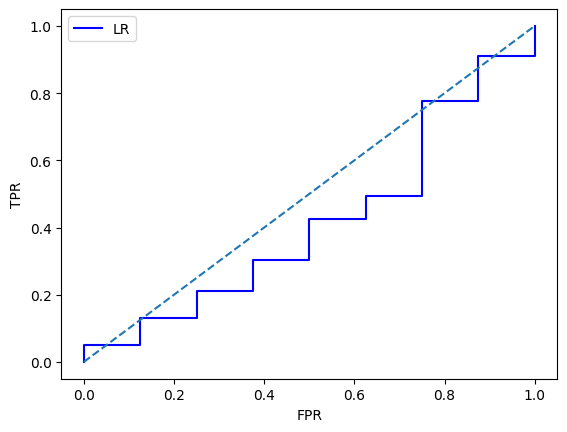

In [ ]:
LR = LogisticRegression(class_weight = {0:13,1:1}, C=0.5963623316594636)
LR.fit(X_train, Y_train)
y_pred = LR.predict(X_test)
proba = LR.predict_proba(X_test)

fpr1, tpr1, trshld1 = roc_curve(Y_test, proba[:,1])
plt.step(fpr1, tpr1, color='b',
         where='post',label='LR')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

ROC кривая, к сожалению, показывает плохое качество модели. Она работает почти как рандом.

Таким образом, можно сделать вывод, что на имеющемся наборе данных неэффективно проводить классификацию, разделяя клиентов на прибыльных и убыточных. Уверен, что дело в дисбалансе классов.

In [ ]:
#feature importance
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': LR.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)
importances

,Attribute,Importance
20,Офис находится в здании партнера/друга/родстве...,1.070523
21,Заемщик от партнера и был подготовлен к ВИ,0.888347
3,В компании была смена учредителя,0.736894
9,Не знает объем выручки,0.536868
14,Нерелевантный опыт работы,0.329420
18,"Есть ""партнер"", который официально не оформлен",0.307212
7,Текущее ЮЛ основано до 30 лет,0.266286
5,Первое ЮЛ,0.061240
6,Выручка компании в первый год > 30 млн.,0.052452
17,Данные предоставленные заемщиком разнятся с де...,0.036351


В таблице выше представлены feature importance перменных.
Некоторые веса распределены достаточно логично, с точки зрения смысла переменных.

Таким образом, если останавливаться на данной модели, то в первую очередь необходимо обращать внимание на первые 7 и последние 6 переменных. Они имеют наибольший вес в модели, а значит определяют прибыльность и убыточность клиентов.

P.S. Добавлю, что также использовал методы oversampling, чтобы избавиться от дисбаланса классов, однако к улучшению результатов работы моделей это не привело. Код представлен ниже.

In [ ]:
from imblearn.over_sampling import SMOTE

data_cl = data.copy()
for i in data_cl.columns[:-1]:
    data_cl[i] = data_cl[i].astype(int)
data_cl['target'] = np.where(data_cl['ProfitPercentage'] < 0, 0, 1)
target = data_cl['target']
data_cl = data_cl.drop('ProfitPercentage', axis=1)

# Resample the minority class.
sm = SMOTE(sampling_strategy='minority', random_state=7)
oversampled_data, oversampled_target = sm.fit_resample(data_cl.drop('target', axis=1), data_cl['target'])

#train test split
X_train,X_test,Y_train,Y_test = train_test_split(oversampled_data, oversampled_target, test_size=0.2,random_state=123)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(788, 22) (198, 22) (788,) (198,)


In [ ]:
RFC = RandomForestClassifier()

cv = KFold(n_splits=5, shuffle=True, random_state=123)

params_grid_RFC = {'n_estimators': range(10,200,10),
                  'max_features':['sqrt', 'log2', None],
                  'criterion':['gini', 'entropy'],}

gs = GridSearchCV(RFC, param_grid=params_grid_RFC, cv = cv)
gs.fit(X_train, Y_train)
print(f'Random Forest performance\n{gs.best_params_}')
print(f'f1_score {round(f1_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, accuracy {round(accuracy_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, precision {round(precision_score(Y_test,gs.best_estimator_.predict(X_test)),3)}, recall {round(recall_score(Y_test,gs.best_estimator_.predict(X_test)),3)}')

y_pred = gs.best_estimator_.predict(X_test)

confusion_matrix(Y_test,y_pred, labels=(1,0))

Random Forest performance
{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 170}
f1_score 0.753, accuracy 0.768, precision 0.875, recall 0.66


array([[70, 36],
       [10, 82]])

Модель теперь лучше определяет убыточных клиентов, однако много ошибается с прибыльными, записавая их как убыточных.